# Scikit-multiflow

`scikit-multiflow` is an open source framework for multi-output/multi-label and stream data mining. It is being developed by  **Télécom ParisTech** and  **École Polytechique**. 
For this lab we will be using `scikit-multiflow`. Visit the page of the [framework](https://scikit-multiflow.github.io/) and follow the [installation guidelines](https://scikit-multiflow.github.io/scikit-multiflow/installation.html).
**Notice:** `scikit-multiflow` requires `NumPy`
Also, for this lab you will need: `pandas` and `matplotlib`.

# Classification in Data Streams

The goal of this lab is to build a classifier capable of learning and making predictions in a datastream using the `scikit-multiflow` framework. In this lab we are comparing three datastream classifiers on Electricity dataset:
- kNN
- Hoeffding Tree
- Batch-Incremental Ensemble Classifier (BIE)

The last of the three classifiers is not implemented yet. This is the task of this lab. You should implement the `predict` and `partial_fit` functions in the `BatchClassifier` class. Implement a tumbling window of size 100, creating and maintaining up to a maximum of 100 models. Build a `DecisionTreeClassifier` on each of the batches/windows.

In [16]:
from numpy import *

from sklearn.tree import DecisionTreeClassifier

class BatchClassifier:

    def __init__(self, window_size=100, max_models=100):
        self.H = []
        self.h = None
        self.window_size = window_size
        self.max_models = max_models

    def partial_fit(self, X, y=None, classes=None):
        # TODO 
        N, D = X.shape
        if len(self.H) == 0:
            X_batch = zeros((self.window_size,D))
            y_batch = zeros(self.window_size)
        # N.B.: The 'classes' option is not important for this classifier
        # HINT: You can build a decision tree model on a set of data like this:
        for i in range(N//self.window_size):
            X_batch = X[i*self.window_size : (i+1)*self.window_size]
            y_batch = y[i*self.window_size : (i+1)*self.window_size]
            h = DecisionTreeClassifier()
            h.fit(X_batch,y_batch)
            self.H.append(h) # <-- and append it to the ensemble
        return self

    def predict(self, X):
        N, D = X.shape
        y_predict = zeros(N)
        if len(self.H) == 0:
            return y_predict      
        for h in self.H:
            y_predict = y_predict + h.predict(X)/len(self.H)
        return (y_predict>=0.5)*1
            
         

## Evaluation

The following piece of code evaluates the three classifiers and gives the online visualization. It computes the current and global values for `accuracy` and `kappa`. Current value of selected evaluation measure represents the performance of the model on the current window and global value represents the performance of the model on whole datastream. `EvaluatePrequential` also gives the summary of evaluation showing the `Evaluation Time`. It, also, writes the metrics data into a file `result_elec.csv` which will be used in the next part to generate plots for comparing current and global performance of the classifiers.

<IPython.core.display.Javascript object>


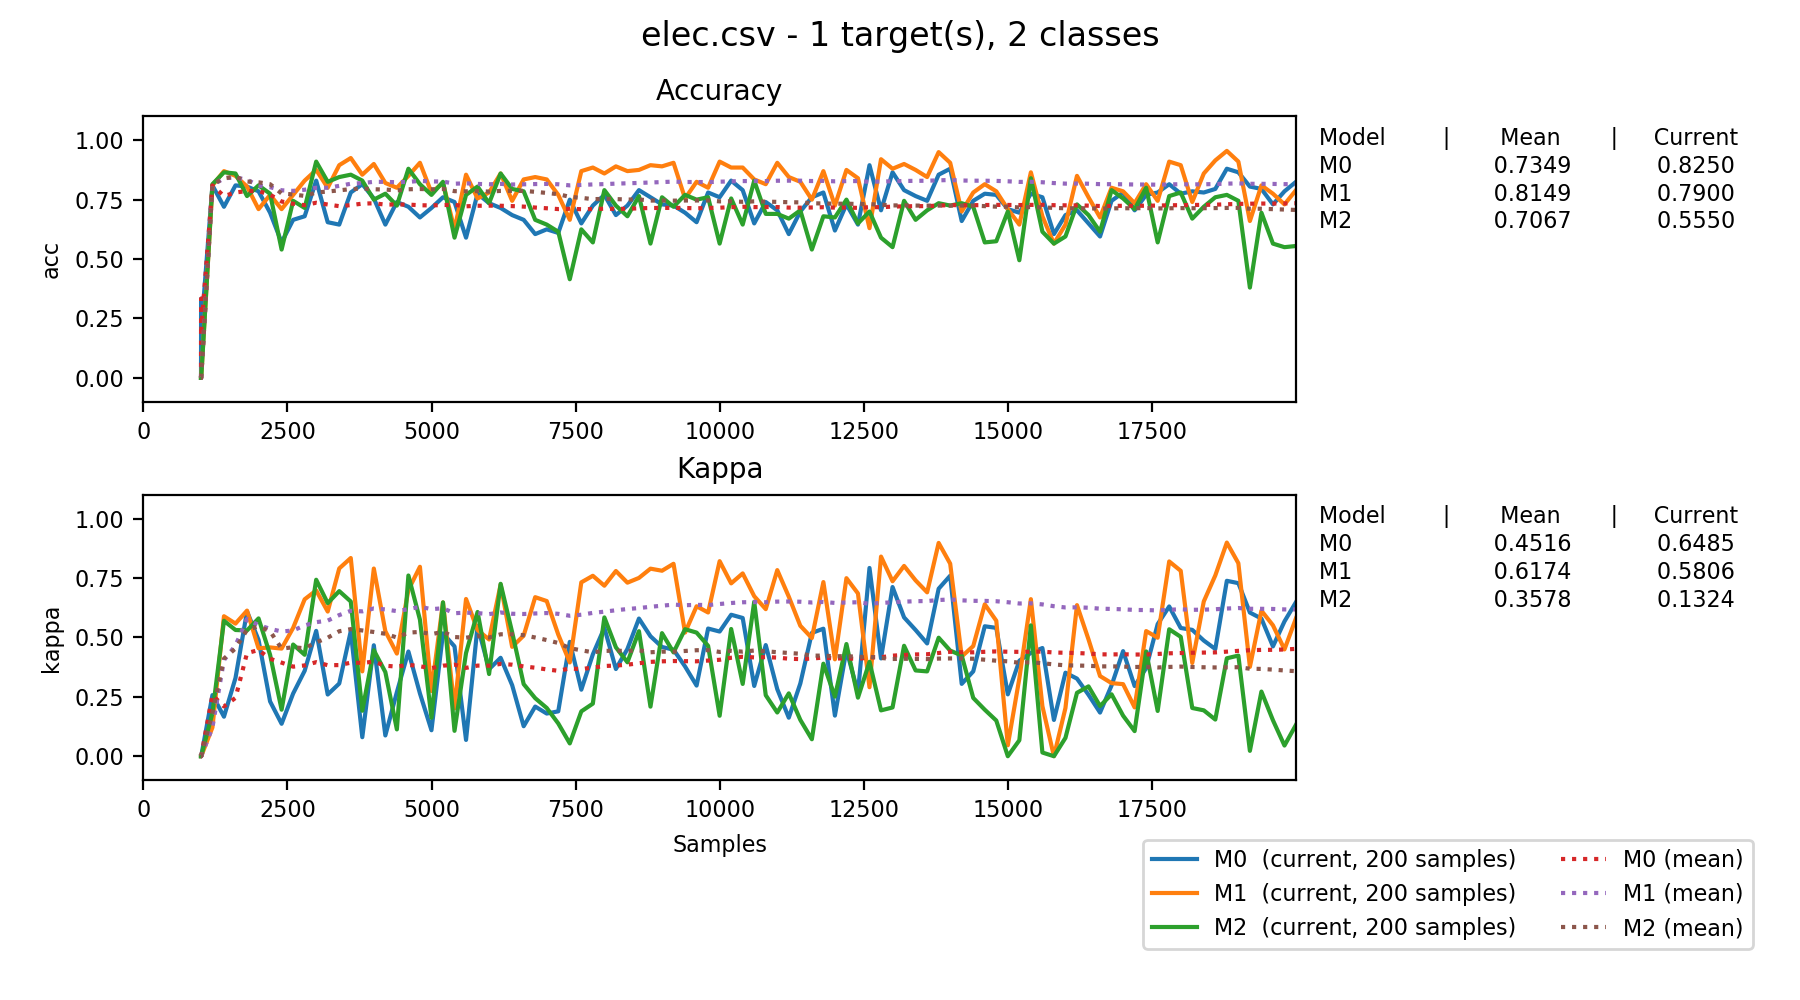

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #################### [100%] [30.20s]
Processed samples: 20000
Mean performance:
M0 - Accuracy     : 0.7349
M0 - Kappa        : 0.4516
M1 - Accuracy     : 0.8149
M1 - Kappa        : 0.6174
M2 - Accuracy     : 0.7067
M2 - Kappa        : 0.3578


[KNN(leaf_size=30, max_window_size=100, n_neighbors=10, nominal_attributes=None),
 HoeffdingTree(binary_split=False, grace_period=200, leaf_prediction='nba',
               max_byte_size=33554432, memory_estimate_period=1000000,
               nb_threshold=0, no_preprune=False, nominal_attributes=None,
               remove_poor_atts=False, split_confidence=1e-07,
               split_criterion='info_gain', stop_mem_management=False,
               tie_threshold=0.05),

In [17]:
%matplotlib notebook
%matplotlib ipympl
from skmultiflow.trees import HoeffdingTree
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
from skmultiflow.lazy.knn_adwin import KNNAdwin, KNN
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from skmultiflow.data.file_stream import FileStream
import matplotlib as plt

plt.interactive(True)

dataset = "elec"

# 1. Create a stream

stream = FileStream("./data/"+dataset+".csv", n_targets=1, target_idx=-1)
# 2. Prepare for use
stream.prepare_for_use()
# 2. Instantiate the HoeffdingTree classifier
h = [
        KNN(n_neighbors=10, max_window_size=100, leaf_size=30),
        HoeffdingTree(),
        BatchClassifier(window_size=100, max_models=100),
     ]

# 3. Setup the evaluator

evaluator = EvaluatePrequential(pretrain_size=1000, max_samples=20000, show_plot=True, 
                                metrics=['accuracy', 'kappa'], output_file='result_'+dataset+'.csv', 
                                batch_size=1)
# 4. Run
evaluator.evaluate(stream=stream, model=h)

## Generating plots

The code given below is using the file `result_elec.csv` created by the `Evaluateprequential` in the previous section to generate the plots for current and global values of `accuracy` and `kappa` and generates the `.pdf` file of the figure. 

<IPython.core.display.Javascript object>


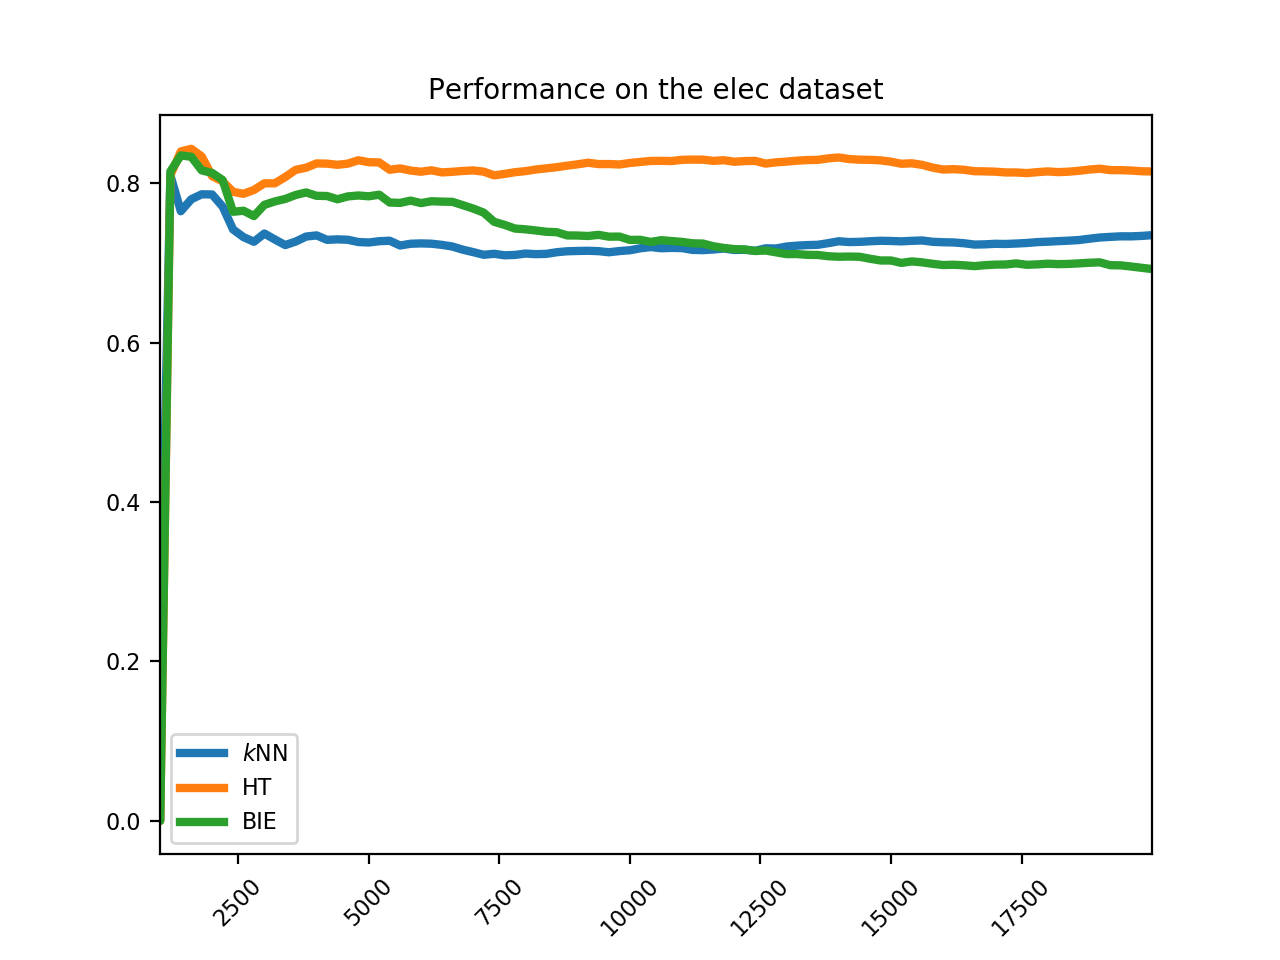

write out to elec ....pdf


In [15]:
import pandas as pd
from matplotlib.pyplot import *

dataset = "elec"

df = pd.read_csv('result_'+dataset+'.csv', comment='#')
ax = df.plot(x="id", y=["mean_acc_[M0]","mean_acc_[M1]","mean_acc_[M2]"], rot=45, linewidth=3, title=dataset)
#ax = df.plot(x="id", y=["current_acc_[M0]", "current_acc_[M1]", "current_acc_[M2]"], rot=30, linewidth=3, title=dataset)
#ax = df.plot(x="id", y=["mean_kappa_[M0]","mean_kappa_[M1]","mean_kappa_[M2]"], rot=45, linewidth=3, title=dataset)
#ax = df.plot(x="id", y=["current_kappa_[M0]", "current_kappa_[M1]", "current_kappa_[M2]"], rot=30, linewidth=3, title=dataset)
ax.set_xlabel("")
ax.set_title("Performance on the %s dataset" % dataset)
ax.legend([r"$k$NN", "HT", "BIE"], loc='best')
print("write out to %s ..." % dataset+".pdf")
savefig("result_"+dataset+".pdf")
show()

## Deliverables

You should submit:
1. The Jupyter Notebook 
2. `html` version of notebook (go to: `File/Download as/HTML`), with visible outputs of your code

in a compressed file (`.zip`, `.rar`, `tar.gz`...), and compressed file should be named: `firstname_lastname_lab2.zip`